# MAE6292 - Homework \# 6

Stereo Rectification

## Import Modules



In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg as linalg
import cv2
import scipy.signal
import scipy.spatial.distance
from mae6292.imshow import cv2_imshow
import mae6292.tools as mae6292

import importlib

## Load Data

Several pictures of an object have been taken with a checkerboard. Then, the camera is calibrated as we have done in HW#2 to obtain the intrinsic parameter $K$ and the camera pose $(R,T)$. The image has been further undistorted.

Those images and the calibration results are loaded as follows.

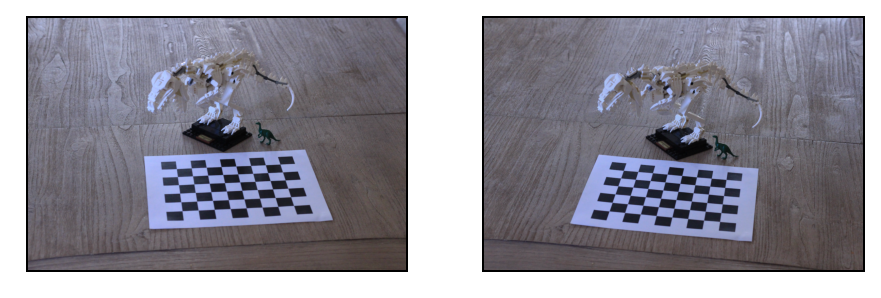

In [2]:
cimg_left = cv2.imread('IMG_left.png')
cimg_right = cv2.imread('IMG_right.png')

img_left = cv2.cvtColor(cimg_left, cv2.COLOR_BGR2GRAY)
img_right = cv2.cvtColor(cimg_right, cv2.COLOR_BGR2GRAY)

fig, ax = plt.subplots(1, 2, dpi=180)
ax[0].imshow(cv2.cvtColor(cimg_left, cv2.COLOR_BGR2RGB))
ax[1].imshow(cv2.cvtColor(cimg_right, cv2.COLOR_BGR2RGB))
for a in ax:
    a.set_xticks([])
    a.set_yticks([])



In [3]:
np.set_printoptions(precision=5)

with np.load('HW6.npz') as data:
    K_left = data['K_left']
    R_left = data['R_left']
    T_left = data['T_left']
    K_right = data['K_right']
    R_right = data['R_right']
    T_right = data['T_right']

    
print('K_left = ',K_left)
print('R_left = ',R_left)
print('T_left = ',T_left)
print('K_right = ',K_right)
print('R_right = ',R_right)
print('T_right = ',T_right)

K_left =  [[2.91173e+03 0.00000e+00 6.35678e+02]
 [0.00000e+00 2.69204e+03 4.19894e+02]
 [0.00000e+00 0.00000e+00 1.00000e+00]]
R_left =  [[ 0.99389  0.1087  -0.01933]
 [-0.0424   0.53746  0.84222]
 [ 0.10194 -0.83625  0.53878]]
T_left =  [[-2.63424]
 [ 1.94637]
 [57.74459]]
K_right =  [[2.91173e+03 0.00000e+00 6.35678e+02]
 [0.00000e+00 2.69204e+03 4.19894e+02]
 [0.00000e+00 0.00000e+00 1.00000e+00]]
R_right =  [[ 0.99077 -0.13301 -0.02625]
 [ 0.09315  0.52717  0.84464]
 [-0.09851 -0.83929  0.53469]]
T_right =  [[-3.29693]
 [ 2.10749]
 [58.88515]]


## Problem 1 (Stereo Rectification)
 
### (a) Convert intrinsic/extrinsic paramters

The perspective projection equation is given by
\begin{align*}
    \lambda_{lr} \begin{bmatrix} u_{lr} \\ v_{lr}\\ 1 \end{bmatrix} = K_{lr} \left( R_{lr} \begin{bmatrix} X_w \\ Y_w \\ Z_w \end{bmatrix} + T_{lr} \right)
\end{align*}
for $lr\in\{left, right\}$.

As discussed in class, for stereo rectification, the above is rewritten into
\begin{align*}
    \lambda_i \begin{bmatrix} u_i \\ v_i \\ 1 \end{bmatrix} = K_i R_i^T \left( \begin{bmatrix} X_w \\ Y_w \\ Z_w \end{bmatrix} - C_i \right)
\end{align*}
for $i\in\{1,2\}$.

It is trivial to see that $K_1= K_{left}$ and $K_2=K_{right}$. Find the expression for $R_1,R_2,C_1,C_2$, and compute and print those.

Verity 
```
R1= [[ 0.99389 -0.0424   0.10194]
 [ 0.1087   0.53746 -0.83625]
 [-0.01933  0.84222  0.53878]]
C2= [[  8.8709 ]
 [ 47.87206]
 [-33.35184]]
```

In [ ]:




print('R1=',R1)
print('C1=',C1)

print('R2=',R2)
print('C2=',C2)

### (b) Find the intrinsic/extrinsic parameters for rectified frame

In class, we discussed the followig choice for the rectified frame. 

\begin{align*}
    \bar K & = \frac{1}{2} (K_1 + K_2 ),\\
    \bar R & = [\bar r_1, \bar r_2, \bar r_3],\\
    \bar r_1 & = \frac{C_2-C_1}{\|C_2-C_1\|},\\
    \bar r_2 & = R_1 e_3 \times \bar r_1,\\
    \bar r_3 & = \bar r_1 \times \bar r_2.
\end{align*}
where $e_3 = [0,0,1]^T$. Thus $R_1e_3$ corresponds to the third column of $R_1$.

Compute `K_bar` and `R_bar` using the above expressions, and print those. You may need to use
* [linalg.norm()](https://docs.scipy.org/doc/scipy/reference/generated/scipy.linalg.norm.html)
* [np.cross()](https://numpy.org/doc/stable/reference/generated/numpy.cross.html)
* [np.concatenate()](https://numpy.org/doc/stable/reference/generated/numpy.concatenate.html)

Verity that
```
K_bar= [[2.91173e+03 0.00000e+00 6.35678e+02]
 [0.00000e+00 2.69204e+03 4.19894e+02]
 [0.00000e+00 0.00000e+00 1.00000e+00]]
R_bar= [[ 0.99856  0.02278  0.04849]
 [ 0.02838  0.54265 -0.83777]
 [-0.04553  0.83794  0.54122]]
```

In [ ]:

print('K_bar=',K_bar)
print('R_bar=',R_bar)

### (c) Homography

1. Let $(u_i,v_i)$ be the pixel coordinates in the image for $i\in\{1,2\}$, and let $(\bar u_i, \bar v_i)$ be the cooresponding pixel cooridnates in the rectififed frame. We have

\begin{align*}
    \bar\lambda_i \begin{bmatrix} \bar u_i \\ \bar v_i \\ 1 \end{bmatrix} = \lambda_i H_i  \begin{bmatrix} u_i \\ v_i \\ 1 \end{bmatrix}
\end{align*}
where
\begin{align*}
H_i = \bar K  \bar R^T R_i K_i^{-1}.
\end{align*}
Therefore, $H_i\in\Re^{3\times 3}$ represents the homography from the original image to the rectified image.
We do not need the value of $\lambda_i, \bar\lambda_i$ as the homogeneous coordinates will be divided by its last element anyway. In order words, it is safe to use
\begin{align*}
\frac{\bar\lambda_i}{\lambda_i} \bar p_i = \frac{\bar\lambda_i}{\lambda_i} \begin{bmatrix} \bar u_i \\ \bar v_i \\ 1 \end{bmatrix} =  H_i  \begin{bmatrix} u_i \\ v_i \\ 1 \end{bmatrix} = H_i p_i
\end{align*}
Using the above equation, the pixel $(u_i,v_i)$ in the original image can be transformed to $(\bar u_i, \bar v_i)$ in the rectified image. 

However, even if we iterate the above transformation for every possible $(u_i,v_i)$, some of pixels in the rectified image is not visited. Therefore, we take the inverse as
\begin{align}
\frac{\lambda_i}{\bar\lambda_i} p_i = H_i^{-1} \bar p_i
\end{align}
and transform $(\bar u_i, \bar v_i)$ into $(u_i,v_i)$. 


2. However, there is no guarantee that the transformed coordinates $(u_i, v_i)$ covers the entire image, i.e., some parts of the original image might be clipped.
As such, the rectified image is padded with zeros of the width `W_padding`, and $(\bar u_i, \bar v_i)$ is iterated over the range extended by `W_padding` (even negative values). When the transformed $(u_i,v_i)$ is within the range of the original image, then the pixel is transfomred by 
```
img_left_rec[bar_vi, bar_ui] = img_left[v_i, u_i]
```

The following code shows the above procedure for the grascale image of the left. 



In [ ]:
H1 = K@R.T@R1@linalg.inv(K1)
inv_H1 = linalg.inv(H1)

N_rows, N_cols = img_left.shape
W_padding = 350

img_left_rec = np.ones((N_rows+2*W_padding, N_cols+2*W_padding))*255

for bar_vi in range(N_rows+2*W_padding):
    for bar_ui in range(N_cols+2*W_padding):
        
        bar_pi = np.array([[bar_ui-W_padding],[bar_vi-W_padding],[1]])
        pi = (inv_H1@bar_pi).flatten()
        
        pi = pi[0:2]/pi[2]
        pi = pi.astype(int)
        
        ui = pi[0]
        vi = pi[1]
        
        if ui > 0 and ui < N_cols and vi > 0 and vi < N_rows:
            img_left_rec[bar_vi,bar_ui] = img_left[vi,ui]

cv2_imshow(img_left_rec)

Extend the above code for color images of both left and right, and crop those as
```
img_left_rec_crop = img_left_rec[400:1100,800:1600]
img_right_rec_crop = img_right_rec[400:1100,200:1000]

```
The expected outcome should be similar with the below, except that your results should be in color. Save it as `prob1c.png`

![](prob1c_example.png)

### (d) Discussion

Briefly discuss whether your rectified images satisfy the assumption of the parallel stereo camera, i.e., the same features are on the same row of the left and the right.


## How to Turn in

Make it sure you add the following files to the repository before pusing it back to github.
1. prob1c.png
